## **Bagging and Boosting**

In [1]:
# Connecting to the Google Colab and importing the required packages
import os
from google.colab import drive
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

drive.mount('/content/drive')

datapath = '/content/drive/My Drive/Colab Notebooks/'
os.path.exists(datapath)

Mounted at /content/drive


True

In [2]:
# Function to calculate root mean square error, or test error that will be used in plotting the graphs
def score(y_test, y_pred):

  test_error = np.square(np.subtract(y_test, y_pred)).mean()
  test_error = math.sqrt(test_error)

  return test_error

## **Implementation of AdaBoost algorithm**

In [3]:
# Function to implement AdaBoost
#
# Input:
# Training and Test data
# T : No of rounds of boosting 
# tree_size : To decide wheter the decision tree should be shallow or deep
# 
# Output:
# Predicted labels for test data
# 
# The function will also plot graphs for test error and accuracy as a function of the number of rounds

def ada_fit(x_train, y_train, T, x_test, y_test, tree_size):

  betas = []
  training_errors = []
  tranined_trees = []
  x_axis = []
  y_axis_error = []
  y_axis_accuracy = []

  weights = np.ones(len(y_train)) * 1 / len(y_train)

  for t in range(T):

    if tree_size == 'shallow':
      tree = DecisionTreeClassifier(max_depth = 1)
    else:
      tree = DecisionTreeClassifier()

    tree.fit(x_train, y_train, sample_weight = weights)

    y_train_pred = tree.predict(x_train)

    tranined_trees.append(tree)

    error = (sum(weights * (np.not_equal(y_train, y_train_pred)).astype(int)))/sum(weights)
    training_errors.append(error)

    e = 1e-10
    b = 0.5 * np.log((1 - error + e) / (error + e))
    betas.append(b)
    
    weights = weights * np.exp( (-1) * b * (np.not_equal(y_train, y_train_pred)).astype(int))

    weights /= np.sum(weights)

  pred = []
  for i in range(len(tranined_trees)):
    y_temp = tranined_trees[i].predict(x_test)
    y_axis_error.append(score(y_test, y_temp))
    y_axis_accuracy.append(accuracy_score(y_test, y_temp))
    x_axis.append(i)
    pred.append(betas[i] * y_temp)

  y_pred = np.sum(pred, axis = 0)
  y_pred = np.sign(y_pred)

  plt.xticks([x for x in range(0,T,math.ceil(T/10))])
  plt.plot(x_axis, y_axis_error)
  plt.xlabel("Number of rounds",fontsize = 15)
  plt.ylabel("Test error",fontsize = 15)
  plt.show()

  plt.xticks([x for x in range(0,T,math.ceil(T/10))])
  plt.plot(x_axis, y_axis_accuracy)
  plt.xlabel("Number of rounds",fontsize = 15)
  plt.ylabel("Accuracy",fontsize = 15)
  plt.show()

  return y_pred



## **Implementation of Bagging**

In [4]:
# Function to implement bagging
#
# Input:
# Training and Test data
# b : No of rounds of bagging
# tree_size : To decide wheter the decision tree should be shallow or deep
# 
# Output:
# Predicted labels for test data
# 
# The function will also plot graphs for test error and accuracy as a function of the number of rounds

def bagged_fit(x_train, y_train, b, x_test, y_test, tree_size):

  tranined_trees = []
  x_axis = []
  y_axis_error = []
  y_axis_accuracy = []

  for x in range(b):

    i = np.random.choice(len(x_train), size=len(x_train))

    x_samples = x_train[i]
    y_samples = y_train[i]

    if tree_size == 'shallow':
      tree = DecisionTreeClassifier(max_depth = 1)
    else:
      tree = DecisionTreeClassifier()

    tree.fit(x_samples, y_samples)

    tranined_trees.append(tree)

  y_pred = np.zeros(len(x_test))

  i = 0
  for tree in tranined_trees:
    y_temp = tree.predict(x_test)
    y_axis_error.append(score(y_test, y_temp))
    y_axis_accuracy.append(accuracy_score(y_test, y_temp))
    x_axis.append(i)
    i += 1
    y_pred = y_pred + y_temp

  plt.xticks([x for x in range(0,b,math.ceil(b/10))])
  plt.plot(x_axis, y_axis_error)
  plt.xlabel("Number of rounds",fontsize = 15)
  plt.ylabel("Test error",fontsize = 15)
  plt.show()

  plt.xticks([x for x in range(0,b,math.ceil(b/10))])
  plt.plot(x_axis, y_axis_accuracy)
  plt.xlabel("Number of rounds",fontsize = 15)
  plt.ylabel("Accuracy",fontsize = 15)
  plt.show()

  return np.round(y_pred/b)

## **Experiment Report**

## 3 datasets, 2 models, 2 trees

## Letter Dataset

In [5]:
# Reading the csv and printing the data to know what we have
letter_data = pd.read_csv(datapath + "letter-recognition.csv")
print(letter_data)

      letter  x-box  y-box  width  height  onpix  x-bar  y-bar  x2bar  y2bar  \
0          T      2      8      3       5      1      8     13      0      6   
1          I      5     12      3       7      2     10      5      5      4   
2          D      4     11      6       8      6     10      6      2      6   
3          N      7     11      6       6      3      5      9      4      6   
4          G      2      1      3       1      1      8      6      6      6   
...      ...    ...    ...    ...     ...    ...    ...    ...    ...    ...   
19995      D      2      2      3       3      2      7      7      7      6   
19996      C      7     10      8       8      4      4      8      6      9   
19997      T      6      9      6       7      5      6     11      3      7   
19998      S      2      3      4       2      1      8      7      2      6   
19999      A      4      9      6       6      2      9      5      3      1   

       xybar  x2ybr  xy2br  x-edge  xeg

In [6]:
# The goal of this is to separate the rows about C and G from the rest of the rows

# These arrays will hold the order of C and G along with arrays of the information about them
all_letter_information = []
current_letter_information = []
letters = []

# Starting with a count of 0, loop through the letters in the letter data
count = 0;
for x in letter_data['letter']:
  letter_information = []
  # If the letter C or G loop through information about it
  if(x == 'C' or x == 'G'):
    for y in letter_data:
      # Put the letter itself into an array containing all letters C and G
      if(y == 'letter'):
        letters.append(letter_data[y][count])
      # Otherwise put information about that letter into an array and then into an array containing all information about all letters
      else:
        letter_information.append(letter_data[y][count])
    all_letter_information.append(letter_information)
  count += 1

# Printing all the length so I know all letters have been gone through
print(len(all_letter_information))
#print(all_letter_information)
print(len(letters))
#print(letters)

1509
1509


In [7]:
# Found train_test_split here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(all_letter_information, letters, test_size=1009, shuffle=True)

# Checking the training data
print(len(x_train_1))
print(len(y_train_1))

print(len(x_test_1))
print(len(y_test_1))

500
500
1009
1009


In [8]:
# Converting the class lables 'C' and 'G' to 0s and 1s
class_encoder = preprocessing.LabelEncoder()
y_train_1 = class_encoder.fit_transform(y_train_1)
y_test_1 = class_encoder.fit_transform(y_test_1)


AdaBoost, Shallow Tree

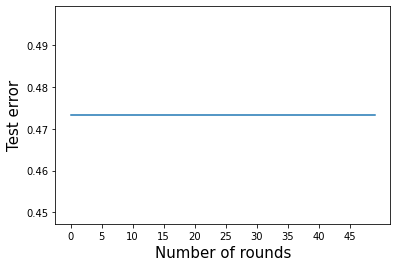

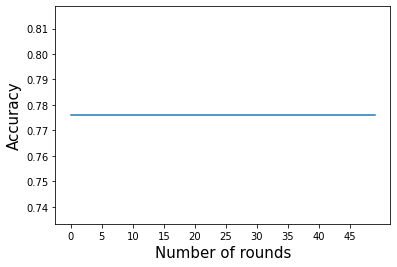

0.77601585728444
0.47326963003721245


In [9]:
ada_y_test_1 = ada_fit(x_train_1, y_train_1, 50, x_test_1, y_test_1, 'shallow')

acc_ada_test_1 = accuracy_score(y_test_1, ada_y_test_1)
print(acc_ada_test_1)

ada_test_1_test_error = score(y_test_1, ada_y_test_1)
print(ada_test_1_test_error)

AdaBoost, Deep Tree

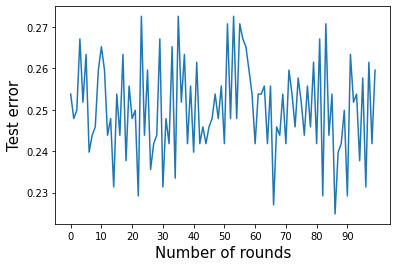

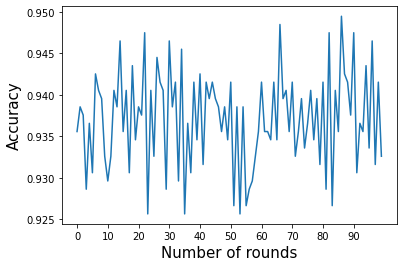

0.9286422200198216
0.2671287704089142


In [10]:
ada_y_test_1 = ada_fit(x_train_1, y_train_1, 100, x_test_1, y_test_1, 'deep')

acc_ada_test_1 = accuracy_score(y_test_1, ada_y_test_1)
print(acc_ada_test_1)

ada_test_1_test_error = score(y_test_1, ada_y_test_1)
print(ada_test_1_test_error)

Bagging, Shallow Tree

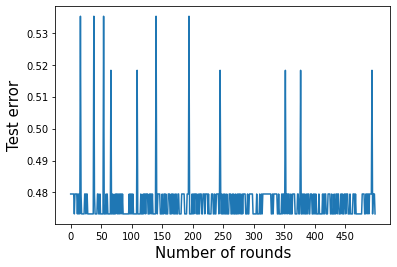

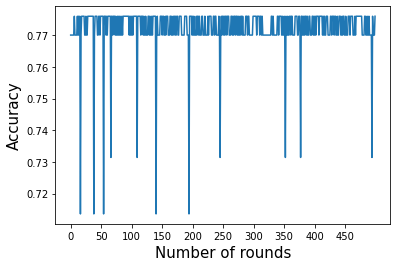

0.77601585728444
0.47326963003721245


In [11]:
bagged_y_test_1 = bagged_fit(np.array(x_train_1), y_train_1, 500, x_test_1, y_test_1, 'shallow')

acc_bagged_test_1 = accuracy_score(y_test_1, bagged_y_test_1)
print(acc_bagged_test_1)

bagged_test_1_test_error = score(y_test_1, bagged_y_test_1)
print(bagged_test_1_test_error)

Bagging, Deep Tree

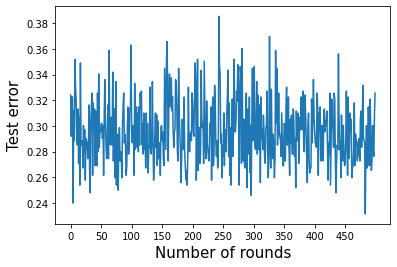

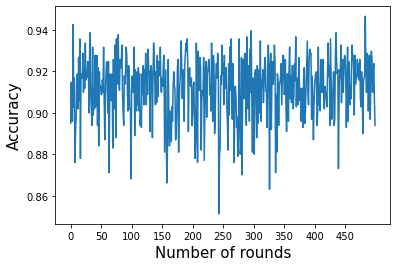

0.9524281466798811
0.21810972770630596


In [12]:
bagged_y_test_1 = bagged_fit(np.array(x_train_1), y_train_1, 500, x_test_1, y_test_1, 'deep')

acc_bagged_test_1 = accuracy_score(y_test_1, bagged_y_test_1)
print(acc_bagged_test_1)

bagged_test_1_test_error = score(y_test_1, bagged_y_test_1)
print(bagged_test_1_test_error)

## Credit Dataset

In [13]:
# Reading the credit data and printing it
credit_data = pd.read_csv(datapath + "german.csv")
print(credit_data)

    checking_status  month_duration credit_history purpose  credit_amount  \
0               A11               6            A34     A43           1169   
1               A12              48            A32     A43           5951   
2               A14              12            A34     A46           2096   
3               A11              42            A32     A42           7882   
4               A11              24            A33     A40           4870   
..              ...             ...            ...     ...            ...   
995             A14              12            A32     A42           1736   
996             A11              30            A32     A41           3857   
997             A14              12            A32     A43            804   
998             A11              45            A32     A43           1845   
999             A12              45            A34     A41           4576   

    savings_account present_employment_since  installment_rate  \
0        

In [14]:
# Setting up some arrays to hold the credit data and how they are classified
all_credit_information = []
current_credit_information = []
credit_classification = []
all_labels = []

# Getting an array of the accurate classifications
for x in credit_data['actual_classification']:
  credit_classification.append(x)

# Putting together an array of the rest of labels to be looped through
for x in credit_data:
  if(x != 'actual_classification'):
    all_labels.append(x)

# Loop through the credit data and the data that is not categorical to an array
for x in range(0, len(credit_data)):
  current_credit_information = []
  for y in all_labels:
    if('A' not in str(credit_data[y][x])):
      current_credit_information.append(credit_data[y][x])
  all_credit_information.append(current_credit_information)

# Checking that data is being printed out right
print(len(all_credit_information))
print(len(credit_classification))
print(len(all_credit_information[0]))
print(all_credit_information[0])

1000
1000
7
[6, 1169, 4, 4, 67, 2, 1]


In [15]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(all_credit_information, credit_classification, test_size=600, shuffle=True)

# Checking the training data
print(len(x_train_2))
print(len(y_train_2))

# Checking the testing data
print(len(x_test_2))
print(len(y_test_2))


400
400
600
600


AdaBoost, Shallow Tree

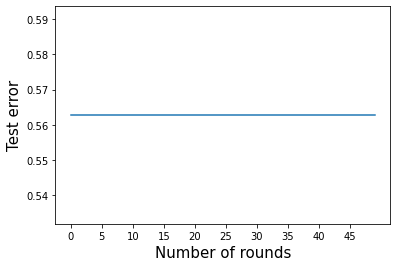

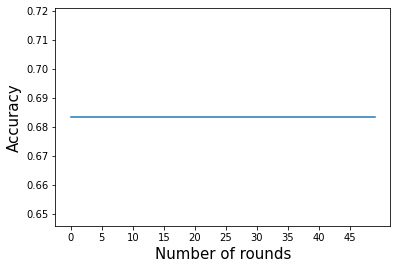

0.6816666666666666
0.5642103626603586


In [16]:
ada_y_test_2 = ada_fit(x_train_2, np.array(y_train_2), 50, x_test_2, y_test_2, 'shallow')

acc_ada_test_2 = accuracy_score(y_test_2, ada_y_test_2)
print(acc_ada_test_2)

ada_test_2_test_error = score(y_test_2, ada_y_test_2)
print(ada_test_2_test_error)

AdaBoost, Deep Tree

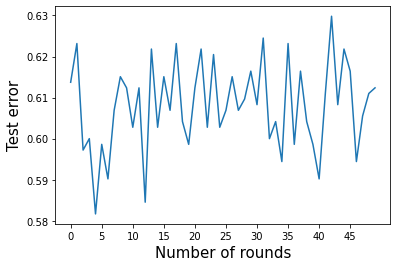

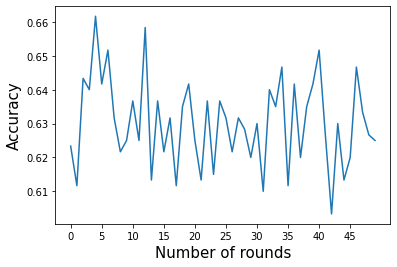

0.9286422200198216
0.5642103626603586


In [17]:
ada_y_test_2 = ada_fit(x_train_2, np.array(y_train_2), 50, x_test_2, y_test_2, 'deep')

acc_ada_test_2 = accuracy_score(y_test_2, ada_y_test_2)
print(acc_ada_test_1)

ada_test_2_test_error = score(y_test_2, ada_y_test_2)
print(ada_test_2_test_error)

Bagging, Shallow Tree

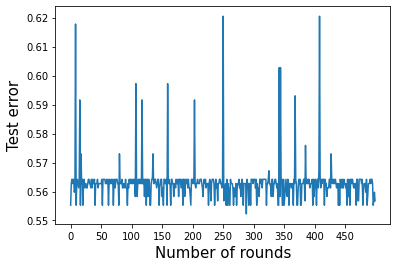

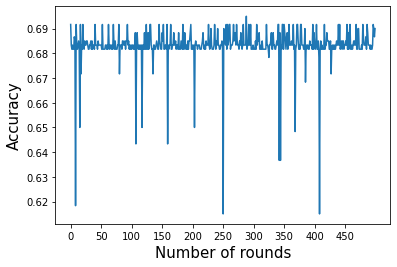

0.6833333333333333
0.5627314338711378


In [18]:
bagged_y_test_2 = bagged_fit(np.array(x_train_2), np.array(y_train_2), 500, x_test_2, y_test_2, 'shallow')

acc_bagged_test_2 = accuracy_score(y_test_2, bagged_y_test_2)
print(acc_bagged_test_2)

bagged_test_2_test_error = score(y_test_2, bagged_y_test_2)
print(bagged_test_2_test_error)

Bagging, Deep Tree

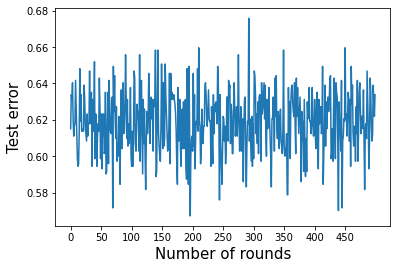

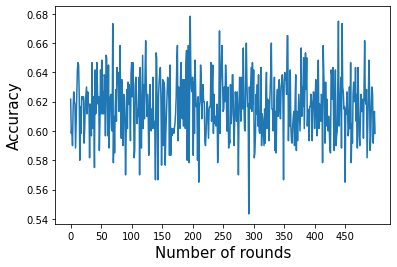

0.685
0.5612486080160912


In [19]:
bagged_y_test_2 = bagged_fit(np.array(x_train_2), np.array(y_train_2), 500, x_test_2, y_test_2, 'deep')

acc_bagged_test_2 = accuracy_score(y_test_2, bagged_y_test_2)
print(acc_bagged_test_2)

bagged_test_2_test_error = score(y_test_2, bagged_y_test_2)
print(bagged_test_2_test_error)

## Spam Dataset

In [20]:
# Reading the spam data and printing it
spam_data = pd.read_csv(datapath + "spambase.csv")
print(spam_data)

      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0               0.00               0.64           0.64           0.0   
1               0.21               0.28           0.50           0.0   
2               0.06               0.00           0.71           0.0   
3               0.00               0.00           0.00           0.0   
4               0.00               0.00           0.00           0.0   
...              ...                ...            ...           ...   
4596            0.31               0.00           0.62           0.0   
4597            0.00               0.00           0.00           0.0   
4598            0.30               0.00           0.30           0.0   
4599            0.96               0.00           0.00           0.0   
4600            0.00               0.00           0.65           0.0   

      word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0              0.32            0.00              0.00     

In [21]:
# Setting up some arrays to hold the spam data and how they are classified
all_spam_information = []
current_spam_information = []
spam_classification = []
all_labels = []

# Getting an array of the accurate classifications
for x in spam_data['spam_classification']:
  spam_classification.append(x)

# Putting together an array of the rest of labels to be looped through
for x in spam_data:
  if(x != 'spam_classification'):
    all_labels.append(x)

# Loop through the spam data and putting it into an array
for x in range(0, len(spam_data)):
  current_spam_information = []
  for y in all_labels:
    current_spam_information.append(spam_data[y][x])
  all_spam_information.append(current_spam_information)

# Printing out the spam data to make sure it is right
print(len(all_spam_information))
#print(all_letter_information)
print(len(spam_classification))
#print(spam_classification)

4601
4601


In [22]:
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(all_spam_information, spam_classification, test_size=3601, shuffle=True)

# Checking the training data
print(len(x_train_3))
print(len(y_train_3))

# Checking the testing data
print(len(x_test_3))
print(len(y_test_3))


1000
1000
3601
3601


AdaBoost, Shallow Tree

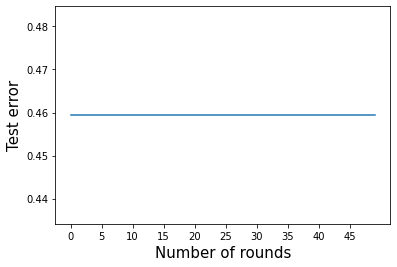

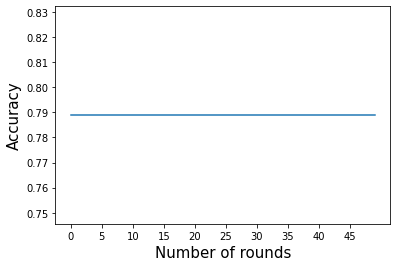

0.7889475145792836
0.45940448998754513


In [23]:
ada_y_test_3 = ada_fit(x_train_3, np.array(y_train_3), 50, x_test_3, y_test_3, 'shallow')

acc_ada_test_3 = accuracy_score(y_test_3, ada_y_test_3)
print(acc_ada_test_3)

ada_test_3_test_error = score(y_test_3, ada_y_test_3)
print(ada_test_3_test_error)

AdaBoost, Deep Tree

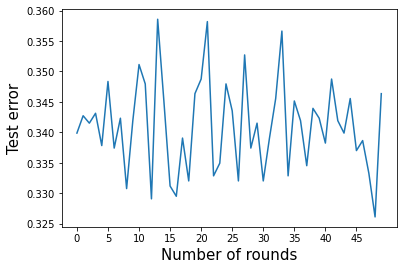

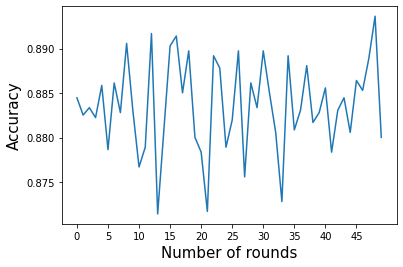

0.8386559289086365
0.40167657523356215


In [24]:
ada_y_test_3 = ada_fit(x_train_3, np.array(y_train_3), 50, x_test_3, y_test_3, 'deep')

acc_ada_test_3 = accuracy_score(y_test_3, ada_y_test_3)
print(acc_ada_test_3)

ada_test_3_test_error = score(y_test_3, ada_y_test_3)
print(ada_test_3_test_error)

Bagging, Shallow Tree

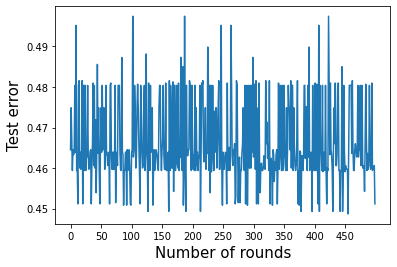

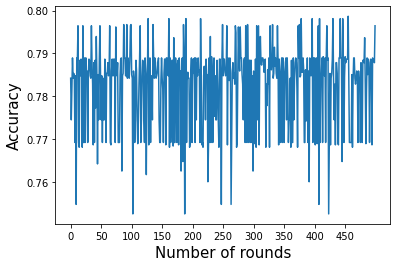

0.7928353235212441
0.45515346475530194


In [25]:
bagged_y_test_3 = bagged_fit(np.array(x_train_3), np.array(y_train_3), 500, x_test_3, y_test_3, 'shallow')

acc_bagged_test_3 = accuracy_score(y_test_3, bagged_y_test_3)
print(acc_bagged_test_3)

bagged_test_3_test_error = score(y_test_3, bagged_y_test_3)
print(bagged_test_3_test_error)

Bagging, Deep Tree

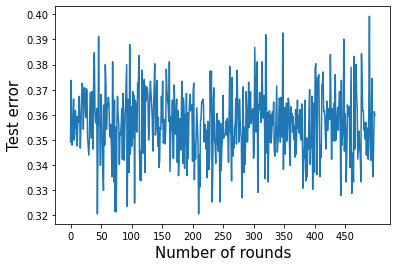

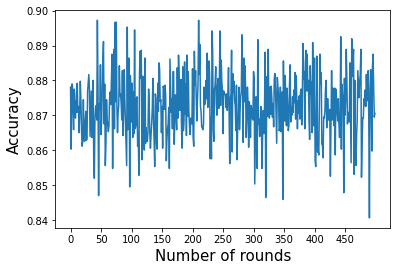

0.9302971396834213
0.2640129927041068


In [26]:
bagged_y_test_3 = bagged_fit(np.array(x_train_3), np.array(y_train_3), 500, x_test_3, y_test_3, 'deep')

acc_bagged_test_3 = accuracy_score(y_test_3, bagged_y_test_3)
print(acc_bagged_test_3)

bagged_test_3_test_error = score(y_test_3, bagged_y_test_3)
print(bagged_test_3_test_error)